  * This notebook was made to look at a big picture of surface currents in the plume area with CODAR data, aiming to get some insights of the currents besides line or point comparison.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime
import scipy.io as sio
import os
import matplotlib.colors as mcolors
import seaborn as sns
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from __future__ import division
from matplotlib import animation

In [2]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')

In [3]:
## load data
codar = sio.loadmat('/ocean/jieliu/research/meopar/salinity_comparison/SoG_radar_totals.mat')
t = codar['mtime']
lat = codar['glat']
lon = codar['glon']
u = codar['u']
v = codar['v']

In [4]:
## initialize the start_time and determine run_time
start_time = datetime.datetime(2014, 10, 8,0)
run_time = datetime.datetime(2014, 10, 8, 0)

In [5]:
from datetime import timedelta
def python_time(run_time):
    run_upper = run_time.replace(minute = 30)
    if run_time.hour != 0:
        run_lower = run_time.replace(hour = run_time.hour-1, minute = 30)
    else:
        run_lower = run_time.replace(day = run_time.day -1,hour =23, minute=30)
    for i,tt  in enumerate(np.arange(0,len(t))):
        matlab_datenum = np.float(t[i])
        python_datetime = datetime.datetime.fromordinal(int(matlab_datenum))\
        + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
        if (python_datetime > run_lower)&(python_datetime < run_upper):
            return python_datetime, i

In [6]:
def plot_codar(run_time):
    axs[0].clear(); axs[1].clear()
    ##plot codar quiver
    viz_tools.plot_coastline(axs[0], grid, coords = 'map')
    viz_tools.plot_coastline(axs[0], grid, coords = 'map', isobath = 5,color = 'OrangeRed')
    axs[0].plot(-123-np.array([18.2,13.7,12])/60.,49+np.array([6.4,8,7.6])/60.,'-k',lw=2,color='Indigo')
    
    p, ind = python_time(run_time)
    quiver = axs[0].quiver(lon, lat,u[:,:,ind], v[:,:,ind],pivot='mid',width=0.005, color='black')
    axs[0].quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                    coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    lonax = [-123.6,-123]
    latax= [48.8,49.4]   
    axs[0].set_xlim(lonax)
    axs[0].set_ylim(latax)
    axs[0].set_xticks([-123.6, -123.4, -123.2,-123])
    axs[0].set_xticklabels([-123.6, -123.4, -123.2,-123])
    plt.setp(axs[0].get_xticklabels(), fontsize=10)
    plt.setp(axs[0].get_yticklabels(), fontsize=10)
    axs[0].set_xlabel('Longitude')
    axs[0].set_ylabel('Latitude')
    axs[0].set_title('codar surface currents on '+p.strftime('%d-%b-%Y %H:%M'), fontsize = 15)
    ## plot ssh at PA
    directory = '/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/'
    path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_T.nc')
    grid_T = nc.Dataset(path,'r')
    ssh =grid_T.variables['sossheig']
    timesteps = grid_T.variables['time_counter'][:]
    t_t = nc_tools.timestamp(grid_T, np.arange(len(timesteps)))
    for ind in range(len(t_t)):
        t_t[ind] = t_t[ind].datetime
    tt = np.array(t_t) 
    start_time = datetime.datetime(2014,10,8,0,0)
    hrs = (run_time.day-start_time.day)*24+ run_time.hour - start_time.hour
    axs[1].plot(tt,ssh[:,466,329],'-k')
    axs[1].plot(tt[hrs],ssh[hrs, 466, 329],'o',color='tomato',markersize=9)
    axs[1].set_ylabel('Water level (m)')
    axs[1].set_title('Modelled water level at Point Atkinson on '+ p.strftime('%d-%b-%Y %H:%M'),fontsize = 15)
    return quiver

In [7]:
#subset
ist=1
ien=398
jst=1
jen=898
x=np.arange(ist,ien)
y=np.arange(jst,jen)
st=3

In [8]:
def plot_ModelCurrent(run_time):
    """This function was made to create modelled surface 
       currents at the corresponding time"""
    directory = '/data/jieliu/MEOPAR/river-treatment/oct8_10reduceviscosity/'
    path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_U.nc')
    grid_U = nc.Dataset(path,'r')
    t = (run_time.day-8)*23+run_time.hour
    u_m =grid_U.variables['vozocrtx'][t, 0,jst-1:jen,ist-1:ien]
    path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_V.nc')
    grid_V = nc.Dataset(path,'r')
    v_m =grid_V.variables['vomecrty'][t, 0,jst-1:jen,ist-1:ien]
    path = os.path.join(directory, 'SalishSea_1h_20141008_20141010_grid_T.nc')
    grid_T = nc.Dataset(path,'r')
    S_m = grid_T.variables['vosaline'][t, 0, jst:jen,ist:ien]
    lon = grid.variables['nav_lon'][jst:jen,ist:ien]
    lat = grid.variables['nav_lat'][jst:jen,ist:ien]
    ##unstagger u v
    U_m,V_m = viz_tools.unstagger(u_m,v_m)
    #rotate
    theta = np.pi*29/180
    U_m = U_m*np.cos(theta) - V_m*np.sin(theta)
    V_m = U_m*np.sin(theta) +V_m*np.cos(theta)
    ##mask
    U_m=np.ma.masked_values(U_m,0)
    V_m=np.ma.masked_values(V_m,0)
    
    mesh=ax.pcolormesh(lon,lat,S_m,cmap='spectral')
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st],U_m[ ::st, ::st], V_m[::st,::st],\
                       pivot='mid',scale=10,width=0.005, color='black' )
    ax.quiverkey(quiver,-123.1,49.35, 1, '1 m/s',
                    coordinates='data', color='black', labelcolor='black',
                fontproperties = {'size': '15'})
    viz_tools.plot_land_mask(ax,grid,coords='map',xslice=x,yslice=y,color='burlywood')
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label('Practical Salinity')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='k')  
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('modelled surface currents and salinity on '+run_time.strftime('%d-%b-%Y %H:%M'),\
                 fontsize = 15)
    return quiver

# plot

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


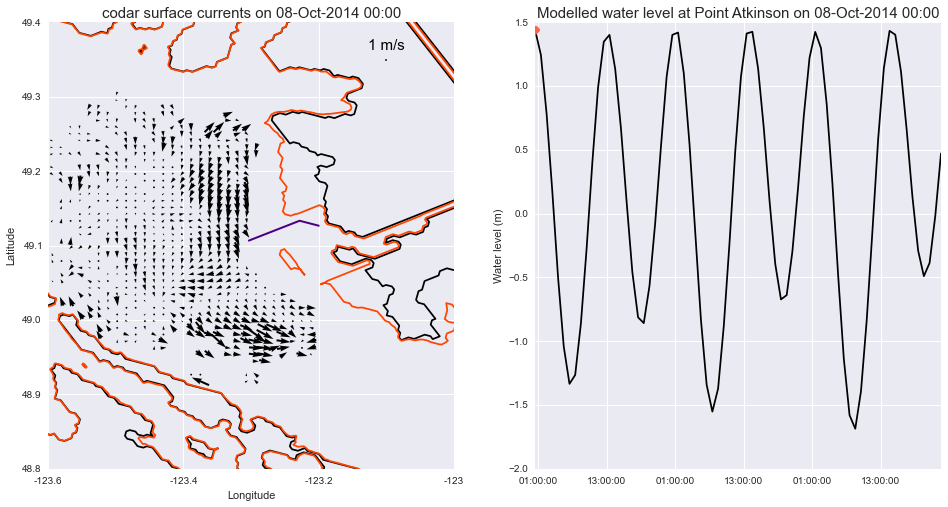

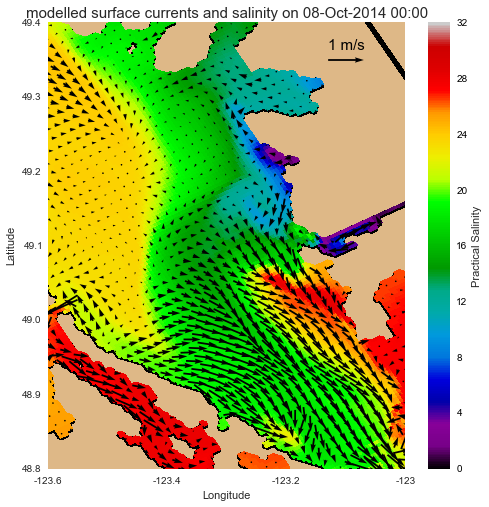

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


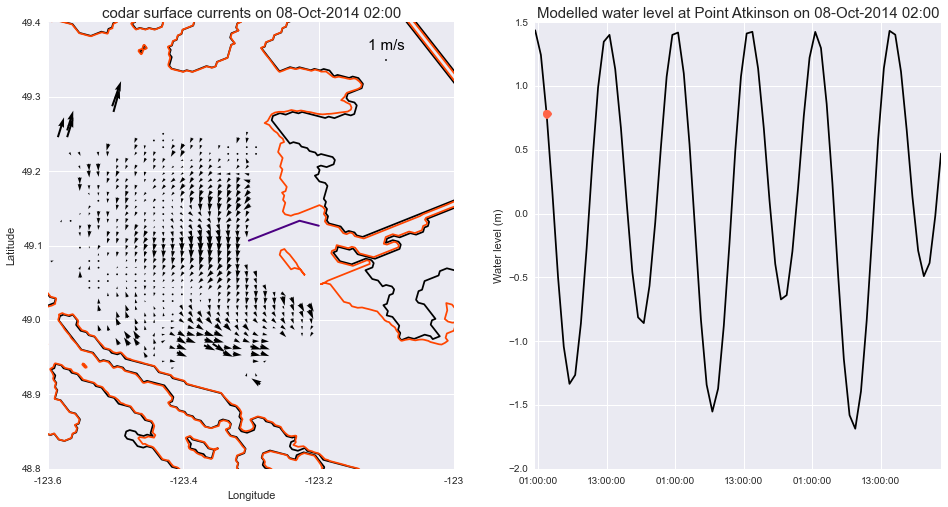

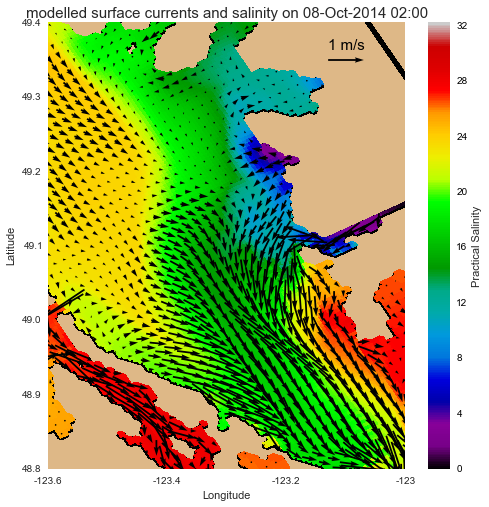

In [10]:
run_time = run_time.replace(hour = 2)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


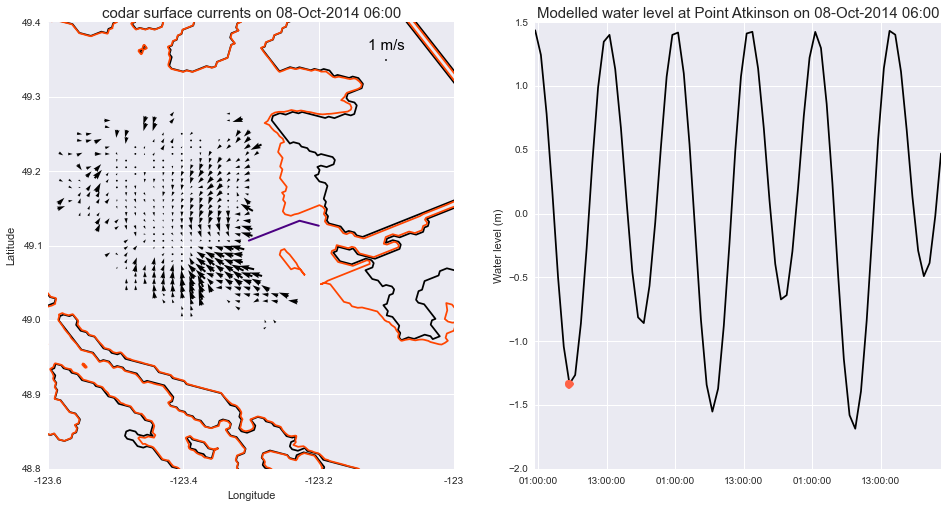

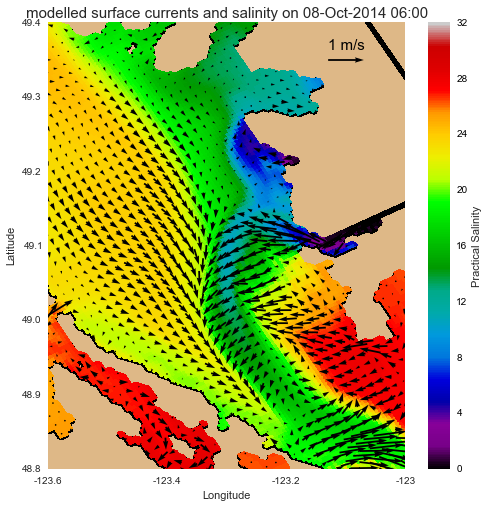

In [11]:
run_time = run_time.replace(hour = 6)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


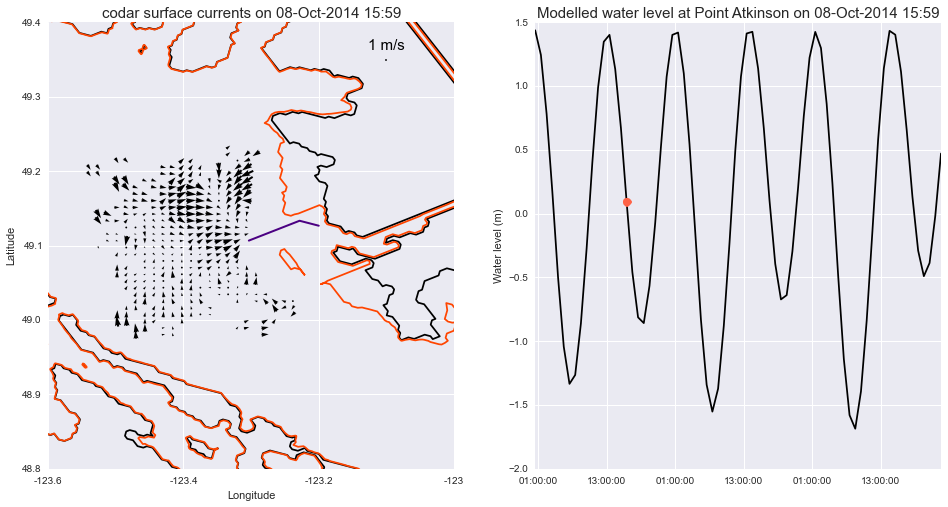

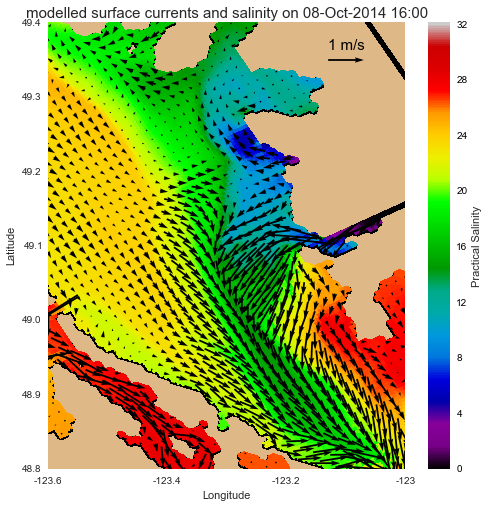

In [12]:
run_time = run_time.replace(hour = 16)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

# For drifter start time on Oct8

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


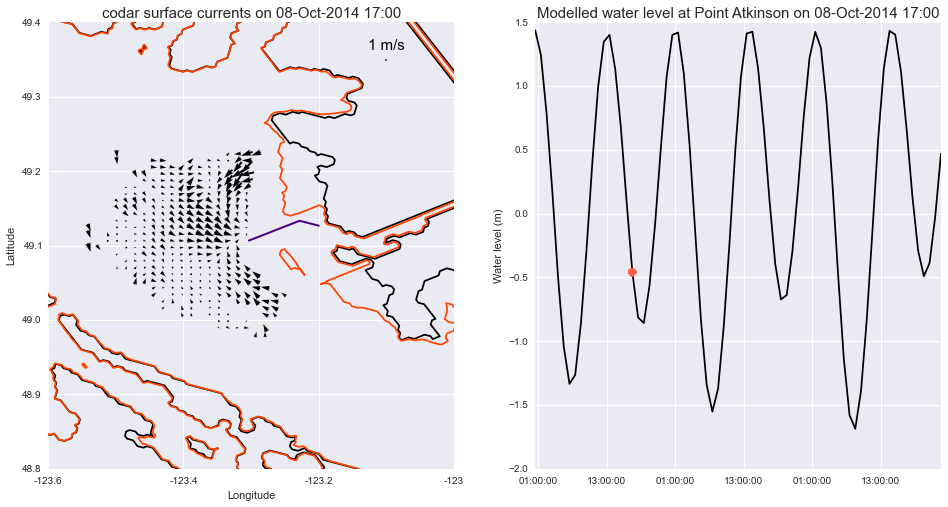

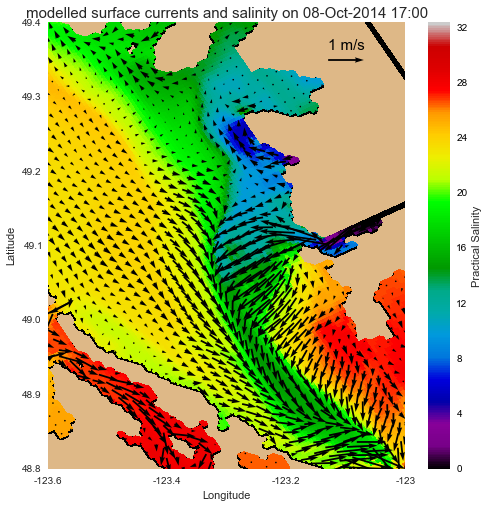

In [13]:
run_time = run_time.replace(hour = 17)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


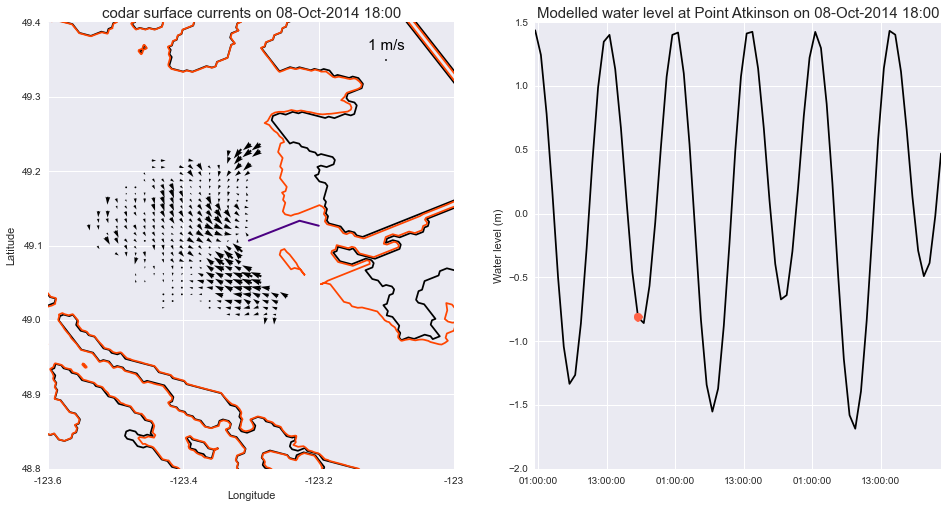

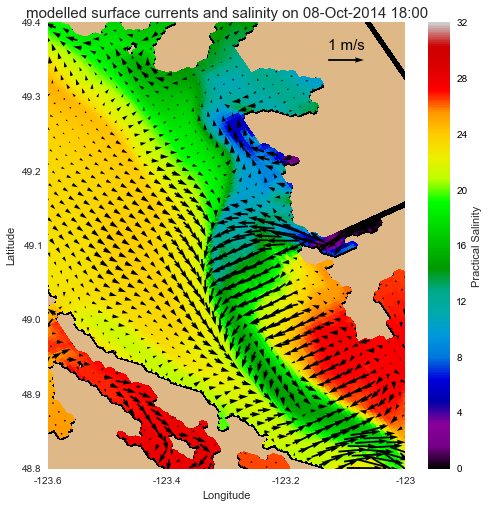

In [14]:
run_time = run_time.replace(hour = 18)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


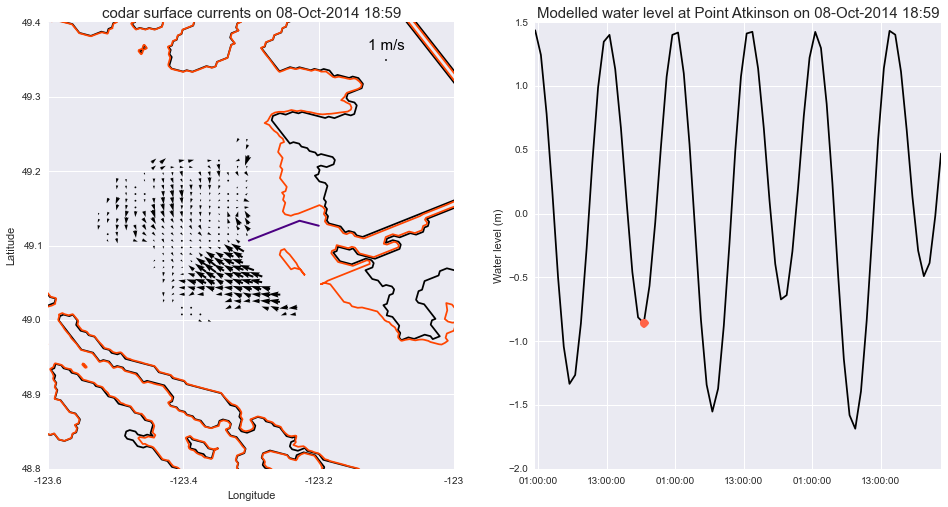

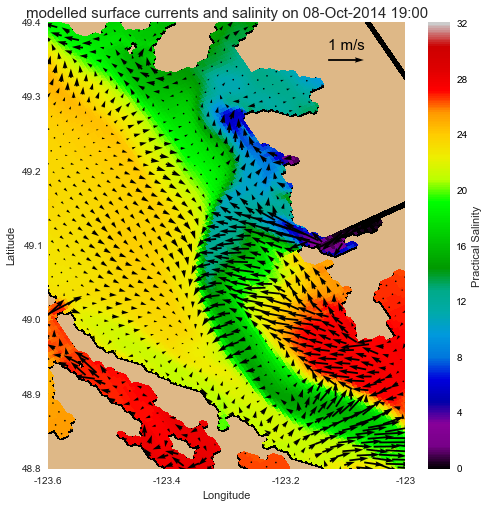

In [15]:
run_time = run_time.replace(hour = 19)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

* What the codar data gives me the feeling like there is a boundary of plume motion separation at around 49.1 latitude, right at the head of jetty, below which strong cross strait velocity is found, above which it goes in the cyclonic rotation during ebb tide. I think two different mechanisms caused this difference. Wind? Tide?

# No data for drifter end time

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


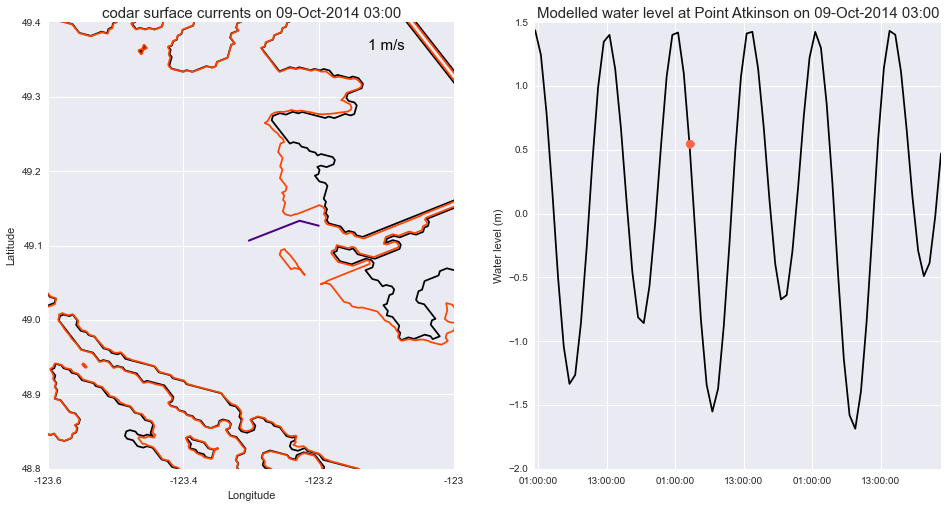

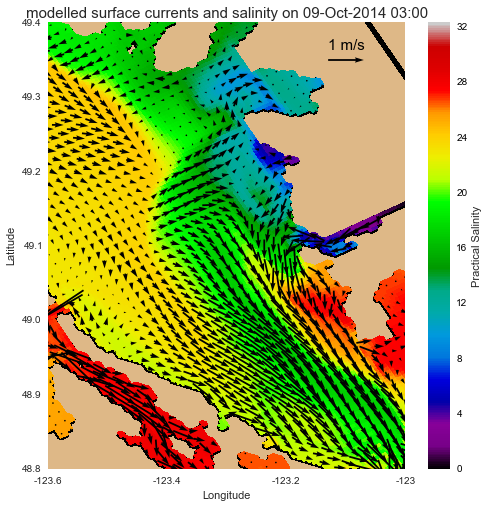

In [16]:
run_time = run_time.replace(hour = 3, day = 9)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


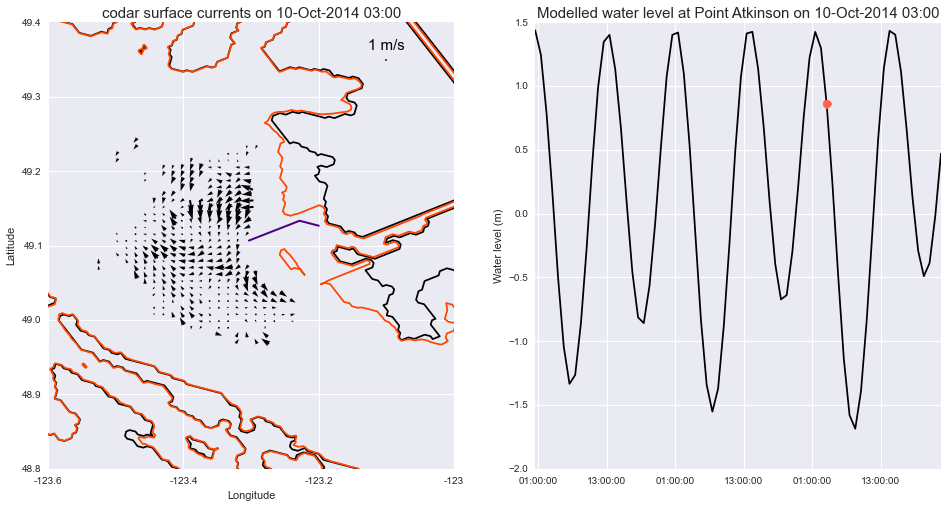

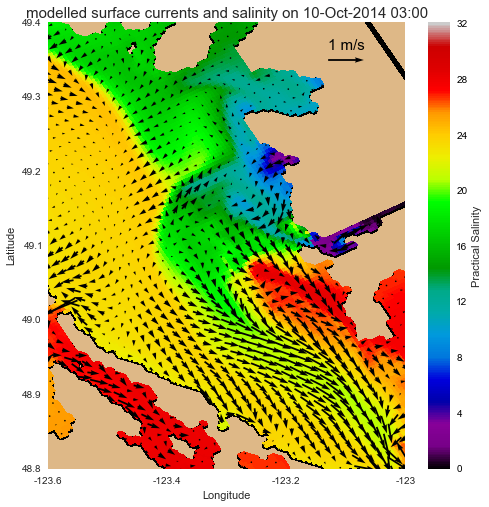

In [17]:
run_time = run_time.replace(hour = 3, day = 10)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
quiver = plot_ModelCurrent(run_time)

* Make an animation

In [18]:
run_time = datetime.datetime(2014,10,8,0)
dateList = []
for x in range (0, 72):
    dateList.append(run_time + datetime.timedelta(hours = x))

/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/jieliu/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face')

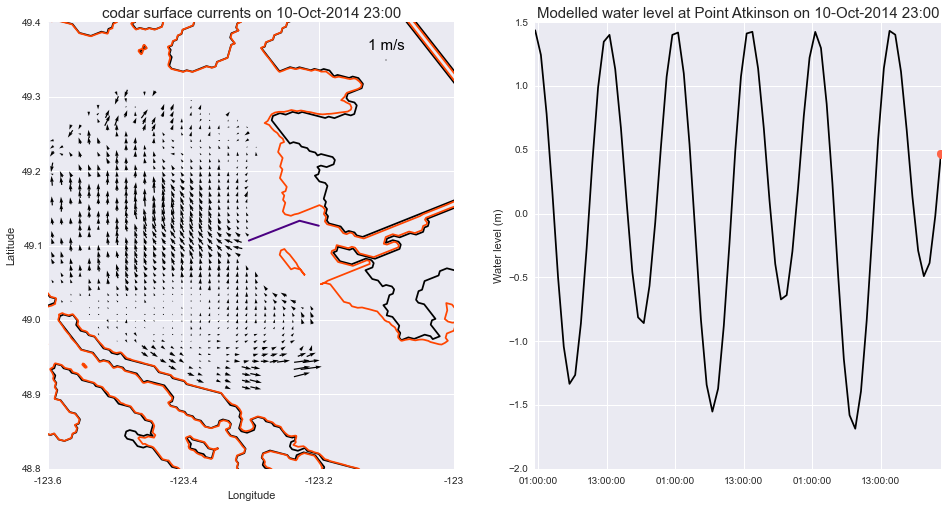

In [24]:
## make animation
#Setting up first frame and static content
run_time = datetime.datetime(2014,10,8,0)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
quiver = plot_codar(run_time)
# list all frames
framess=dateList

#The animation function    
anim = animation.FuncAnimation(fig, plot_codar, frames=dateList,  blit=True, repeat=False)

#A line that makes it all work
mywriter = animation.FFMpegWriter( fps=2, bitrate=10000)
anim.save('codar_current.mp4',writer=mywriter)